# Likelihood Limits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import expon, norm, uniform, gamma
from scipy import stats
from itertools import product, chain
import numba as nb
from scipy.optimize import fsolve, bisect, minimize
from PIL import Image, ImageDraw
import matplotlib as mpl
from tqdm.auto import tqdm, trange
import pdb
%config InlineBackend.figure_formats = ['svg']

In [2]:
fontsize = 12

mpl.rcParams['xtick.labelsize'] = fontsize
mpl.rcParams['ytick.labelsize'] = fontsize
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

Load the data.

In [3]:
NAMES = ['A', 'B', 'C']
EXPOSURE = np.array([7, 5, 100])
COUNTS = np.array([2100, 1000, 2000])
THRESHOLD_LOW = np.array([0.1, 0.035, 1])
THRESHOLD_UP = np.array([20, 10, 400])
RESOLUTION = np.array([0.015, 0.005, 0.15])
EFFICIENCY = np.array([0.8, 0.65, 0.5])
NMBR_REPETITIONS = 6

In [4]:
data_alice = []
data_bob = []
data_carol = []

for i in range(NMBR_REPETITIONS):
    data_alice.append(np.loadtxt('data/alice/data_alice_{}.txt'.format(i)))
    data_bob.append(np.loadtxt('data/bob/data_bob_{}.txt'.format(i)))
    data_carol.append(np.loadtxt('data/carol/data_carol_{}.txt'.format(i)))
    
grids = []
efficiencies = []

grids.append(np.loadtxt('data/alice/efficiency_alice.txt')[:,0])
grids.append(np.loadtxt('data/bob/efficiency_bob.txt')[:,0])
grids.append(np.loadtxt('data/carol/efficiency_carol.txt')[:,0])

efficiencies.append(np.loadtxt('data/alice/efficiency_alice.txt')[:,1])
efficiencies.append(np.loadtxt('data/bob/efficiency_bob.txt')[:,1])
efficiencies.append(np.loadtxt('data/carol/efficiency_carol.txt')[:,1])

data_alice = np.array(data_alice)
data_bob = np.array(data_bob)
data_carol = np.array(data_carol)
grids = np.array(grids)
efficiencies = np.array(efficiencies)

## Exclusion limits with Likelihood

The picture changes for the calculation of limits with a likelihood fit. For this we first need to define the negative extended log likelihood. 

In [5]:
def inbounds(value, low, up):
    # utility function for bounds checks
    if value < low:
        return False, 10**50 + 10**50*np.abs(value - low)
    elif value > up:
        return False, 10**50 + 10**50*np.abs(value - up)
    else:
        return True, 0
    
def nll(pars, x, *args):
    """
    The negative extended log likelihood.
    
    Arguments:
    x, 
    pars,
    signal_model:object,
    signal_pars:dict,
    grid:list,
    efficiency:list,
    bnds:list,
    density:func,
    sig_fixed:float,
    """
    
    signal_model, signal_pars, grid, efficiency, bnds, density, sig_fixed = args
    
    if sig_fixed is not None:
        pars[0] = sig_fixed
    
    # bounds
    for p, (low, up) in zip(pars, bnds):
        ok, retval = inbounds(p, low, up)
        if not ok:
            return retval
    
    # likelihood
    lh = density(pars, x, *args)
    
    # constraint
    nu = np.trapz(density(pars, grid, *args), x=grid)  # integrate in roi
    return nu - np.sum(np.log(lh))

Next, we define the density functions and signal models for the experiments.

In [6]:
def signal_mod(x, args, **kwargs):
    return expon(scale=args[0]).pdf(x)

In [7]:
def density_alice(pars, 
                  x, 
                  signal_model:object,
                  signal_pars:dict,
                  grid:list,
                  efficiency:list,
                  *args
                  ):
    """
    The density function for experiment A.
    """
    
    # 4 components: signal, flat, peak, rise
    w0, w1, w2, w3, = pars  # 4 pars
    
    # signal
    density = w0 * signal_model(x, **signal_pars)
    #flat
    density += w1 * uniform(scale=20).pdf(x)
    #peak
    density += w2 * norm(loc=6, scale=0.5).pdf(x)
    #rise
    density += w3 * expon(scale=0.1).pdf(x)
    
    #efficiency
    density *= np.interp(x, grid, efficiency)  # for performance use callable function
    
    return density

def density_bob(pars, 
                  x, 
                  signal_model:object,
                  signal_pars:dict,
                  grid:list,
                  efficiency:list,
                  *args
                  ):
    """
    The density function for experiment B.
    """
    
    # 4 components: signal, flat, peak, rise
    w0, w1, w2, w3, = pars  # 4 pars
    
    # signal
    density = w0 * signal_model(x, **signal_pars)
    #flat
    density += w1 * uniform(scale=10).pdf(x)
    #peak
    density += w2 * norm(loc=6, scale=0.5).pdf(x)
    #rise
    density += w3 * expon(scale=0.1).pdf(x)
    
    #efficiency
    density *= np.interp(x, grid, efficiency)
    
    return density

def density_carol(pars, 
                  x, 
                  signal_model:object,
                  signal_pars:dict,
                  grid:list,
                  efficiency:list,
                  *args
                  ):
    """
    The density function for experiment C.
    """
    
    # 4 components: signal, gamma + 3 peaks, 2 peaks
    w0, w1, w2, w3, = pars  # 4 pars
    
    # signal
    density = w0 * signal_model(x, **signal_pars)
    #gamma
    density += w1 * gamma(a=2.25, scale=66.67).pdf(x)
    #peak
    density += w1 * 0.2 * norm(loc=45., scale=2.).pdf(x)
    #peak
    density += w1 * 0.3 * norm(loc=75., scale=3.).pdf(x)
    #peak
    density += w1 * 0.125 * norm(loc=120., scale=5.).pdf(x)
    #peak
    density += w2 * norm(loc=200., scale=10.).pdf(x)
    #peak
    density += w3 * norm(loc=300., scale=20.).pdf(x)
    
    #efficiency
    density *= np.interp(x, grid, efficiency)
    
    return density

We need to define bounds, start values and additional arguments for the minimization of the NLL.

In [82]:
LAMB = 1

# experiment A

bnds_alice = [(0, 5e100),  # w0   # bounds from zero to number of events
              (0, 5e100),  # w1
              (0, 5e100),  # w2
              (0, 5e100),  # w3
             ]

x0_alice = np.array([0.*len(data_alice[0])/EFFICIENCY[0],  # w0
            0.4*len(data_alice[0])/EFFICIENCY[0],  # w1
            0.3*len(data_alice[0])/EFFICIENCY[0],  # w2
            0.3*len(data_alice[0])/EFFICIENCY[0],  # w3 
                    ])

args_alice = (data_alice[0],  # x
              signal_mod,  # signal_model
              {'args':(LAMB,)},  # signal_pars
              grids[0],  # grid
              efficiencies[0],  # efficiency
              bnds_alice,  # bnds
              density_alice,  # density
              None, # sig_fixed
             )

# experiment B

bnds_bob = [(0, 5e100),  # w0 
              (0, 5e100),  # w1
              (0, 5e100),  # w2
              (0, 5e100),  # w3
             ]

x0_bob = np.array([0.*len(data_bob[0])/EFFICIENCY[1],  # w0
            0.35*len(data_bob[0])/EFFICIENCY[1],  # w1
            0.3*len(data_bob[0])/EFFICIENCY[1],  # w2
            0.35*len(data_bob[0])/EFFICIENCY[1],  # w3 
                  ])

args_bob = (data_bob[0],  # x
              signal_mod,  # signal_model
              {'args':(LAMB,)},  # signal_pars  
              grids[1],  # grid
              efficiencies[1],  # efficiency
              bnds_bob,  # bnds
              density_bob,  # density
              None, # sig_fixed
             )

# experiment C

bnds_carol = [(0, 5e100),  # w0 
              (0, 5e100),  # w1
              (0, 5e100),  # w2
              (0, 5e100),  # w3
             ]

x0_carol = np.array([0.*len(data_carol[0])/EFFICIENCY[2],  # w0
            0.4*len(data_carol[0])/EFFICIENCY[2],  # w1
            0.15*len(data_carol[0])/EFFICIENCY[2],  # w2
            0.1*len(data_carol[0])/EFFICIENCY[2],  # w3 
                    ])

args_carol = (data_carol[0],  # x
              signal_mod,  # signal_model
              {'args':(LAMB,)},  # signal_pars
              grids[2],  # grid
              efficiencies[2],  # efficiency
              bnds_carol,  # bnds
              density_carol,  # density
              None, # sig_fixed
             )

How does the actual density look like?

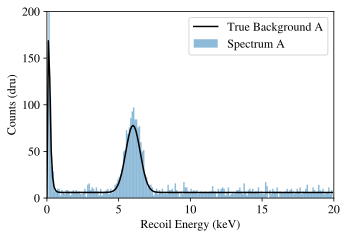

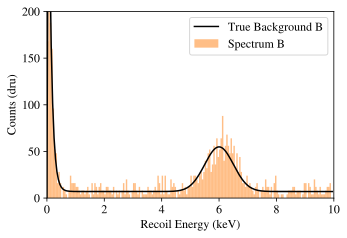

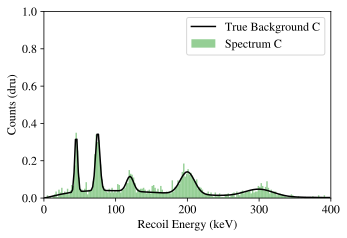

In [9]:
mpl.rcParams['figure.figsize'] = (5, 3.5)

# alice
bin_width = 0.1
ran = (0,20)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_alice[0], bins=bins, weights=1/bin_width/EXPOSURE[0]*np.ones(len(data_alice[0])), alpha=0.5, label='Spectrum A', range=ran, color='C0')

plt.plot(bins, 
         1/EXPOSURE[0]*density_alice(pars=x0_alice, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[0],
                                                      efficiency=efficiencies[0],), 
         color='black', label='True Background A')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,200)
plt.legend()
plt.tight_layout()
plt.show()


# bob
bin_width = 0.05
ran = (0,10)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_bob[0], bins=bins, weights=1/EXPOSURE[1]/bin_width*np.ones(len(data_bob[0])), alpha=0.5, label='Spectrum B', range=ran, color='C1')

plt.plot(bins, 1/EXPOSURE[1]*density_bob(pars=x0_bob, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[1],
                                                      efficiency=efficiencies[1],), 
         color='black', label='True Background B')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,200)
plt.legend()
plt.tight_layout()
plt.show()


# carol
bin_width = 2
ran = (0,400)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_carol[0], bins=bins, weights=1/bin_width/EXPOSURE[2]*np.ones(len(data_carol[0])), alpha=0.5, label='Spectrum C', range=ran, color='C2')

eff = np.interp(bins, grids[2], efficiencies[2])
plt.plot(bins, 1/EXPOSURE[2]*density_carol(pars=x0_carol, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[2],
                                                      efficiency=efficiencies[2],), 
         color='black', label='True Background C')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()


Get the value for the NLL for the start values (these are the correct background values).

In [10]:
print(nll(x0_alice, *args_alice))
print(nll(x0_bob, *args_bob))
print(nll(x0_carol, *args_carol))

-8948.915644273127
-4241.561124267966
-2076.8451827192457


We do a best fit.

In [11]:
res_alice_best = minimize(nll, 
                          x0=x0_alice, 
                          args=args_alice,
                         ) 

print('Result Alice: ')
print(res_alice_best.x)
print(res_alice_best.fun)

res_bob_best = minimize(nll, 
                          x0=x0_bob, 
                          args=args_bob,
                         )

print('Result Bob: ')
print(res_bob_best.x)
print(res_bob_best.fun)

res_carol_best = minimize(nll, 
                          x0=x0_carol, 
                          args=args_carol,
                         )

print('Result Carol: ')
print(res_carol_best.x)
print(res_carol_best.fun)

Result Alice: 
[1.31363116e-01 1.32593187e+03 9.94640480e+02 9.10665152e+02]
-8992.149278181081
Result Bob: 
[ 12.10596574 648.13535873 480.61357107 567.18370669]
-4249.284348880917
Result Carol: 
[   0. 1600.  600.  400.]
-2076.8451827192457


How does the best fit look like?

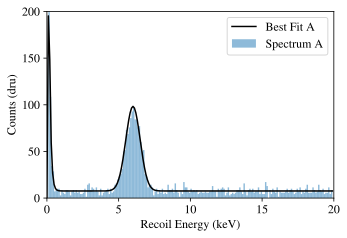

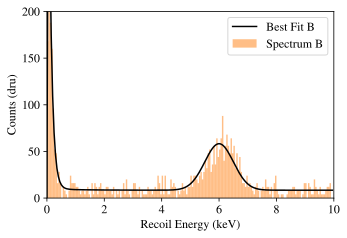

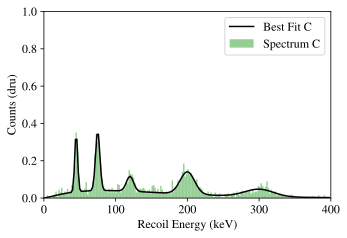

In [12]:
mpl.rcParams['figure.figsize'] = (5, 3.5)

# alice
bin_width = 0.1
ran = (0,20)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_alice[0], bins=bins, weights=1/bin_width/EXPOSURE[0]*np.ones(len(data_alice[0])), alpha=0.5, label='Spectrum A', range=ran, color='C0')

plt.plot(bins, 
         1/EXPOSURE[0]*density_alice(pars=res_alice_best.x, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[0],
                                                      efficiency=efficiencies[0],), 
         color='black', label='Best Fit A')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,200)
plt.legend()
plt.tight_layout()
plt.show()


# bob
# w0, w1, w2, w3, = x0_bob

bin_width = 0.05
ran = (0,10)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_bob[0], bins=bins, weights=1/EXPOSURE[1]/bin_width*np.ones(len(data_bob[0])), alpha=0.5, label='Spectrum B', range=ran, color='C1')

plt.plot(bins, 1/EXPOSURE[1]*density_bob(pars=res_bob_best.x, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[1],
                                                      efficiency=efficiencies[1],), 
         color='black', label='Best Fit B')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,200)
plt.legend()
plt.tight_layout()
plt.show()


# carol
bin_width = 2
ran = (0,400)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_carol[0], bins=bins, weights=1/bin_width/EXPOSURE[2]*np.ones(len(data_carol[0])), alpha=0.5, label='Spectrum C', range=ran, color='C2')

eff = np.interp(bins, grids[2], efficiencies[2])
plt.plot(bins, 1/EXPOSURE[2]*density_carol(pars=res_carol_best.x, 
                                                      x=bins, 
                                                      signal_model=signal_mod,
                                                      signal_pars={'args':(LAMB,)},
                                                      grid=grids[2],
                                                      efficiency=efficiencies[2],), 
         color='black', label='Best Fit C')  #  rise

plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()


Now we calculate the exclusion limit.

In [25]:
do = [0,1,2]

# alice

if 0 in do:

    def implfunc_alice(val): 

        args_alice_excl = (data_alice[0],  # x
                  signal_mod,  # signal_model
                  {'args':(LAMB,), 'grid':grids[0], 'efficiency':efficiencies[0], 'exposure':EXPOSURE[0]},  # signal_pars
                  grids[0],  # grid
                  efficiencies[0],  # efficiency
                  bnds_alice,  # bnds
                  density_alice,  # density
                  val, # sig_fixed
                 )

        return minimize(nll, x0=res_alice_best.x, args=args_alice_excl).fun + res_alice_best.fun + 1.282**2/2

    res_alice_excl = bisect(implfunc_alice, a=res_alice_best.x[0], b=1e8)
    # res_alice_excl = get_root(implfunc_alice, a=res_alice_best.x[0])

    print(res_alice_excl)

# bob

if 1 in do:

    def implfunc_bob(val): 

        args_bob_excl = (data_bob[0],  # x
                  signal_mod,  # signal_model
                  {'args':(LAMB,), 'grid':grids[1], 'efficiency':efficiencies[1], 'exposure':EXPOSURE[1]},  # signal_pars
                  grids[1],  # grid
                  efficiencies[1],  # efficiency
                  bnds_bob,  # bnds
                  density_bob,  # density
                  val, # sig_fixed
                 )

        return minimize(nll, x0=res_bob_best.x, args=args_bob_excl).fun + res_bob_best.fun + 1.282**2/2

    res_bob_excl = bisect(implfunc_bob, a=res_bob_best.x[0], b=1e8)  # TODO get_root

    print(res_bob_excl)

# carol

if 2 in do:

    def implfunc_carol(val): 

        args_carol_excl = (data_carol[0],  # x
                  signal_mod,  # signal_model
                  {'args':(LAMB,), 'grid':grids[2], 'efficiency':efficiencies[2], 'exposure':EXPOSURE[2]},  # signal_pars
                  grids[2],  # grid
                  efficiencies[2],  # efficiency
                  bnds_carol,  # bnds
                  density_carol,  # density
                  val, # sig_fixed
                 )

        return minimize(nll, x0=res_carol_best.x, args=args_carol_excl).fun + res_carol_best.fun + 1.282**2/2

    res_carol_excl = bisect(implfunc_carol, a=res_carol_best.x[0], b=1e8)  # TODO get_root

    print(res_carol_excl)
    
# plot the nu ingegral value ??

27655.09587681463
16102.814061375115
22548.403853747484


For the correct normalization, we need to divide by the number of events and multiply by the exposure.

In [14]:
print(res_alice_excl/COUNTS[0]*EXPOSURE[0])
print(res_alice_excl/COUNTS[1]*EXPOSURE[1])
print(res_alice_excl/COUNTS[2]*EXPOSURE[2])  # grid bin width problem ???

NameError: name 'res_alice_excl' is not defined

Lets streamline the whole procedure and speed it up.

In [18]:
import numba as nb
from math import gamma as ga
from numba import vectorize, float64, njit
SQRT2PI = np.sqrt(2.0 * np.pi)

# normal distribution
@njit
def pdf_normal(x, loc=0., scale=1.):
    u = (x - loc) / scale
    return np.exp(-0.5 * u ** 2) / (SQRT2PI * scale)
    
# exponential distribution
@njit
def pdf_expon(x, scale=1.):
    if 0 < x:
        return np.exp(-x/scale)/scale
    return 0

# uniform distribution
@njit
def pdf_uniform(x, loc=0., scale=1.):
    if loc <= x <= loc + scale:
        return 1 / scale
    return 0

# gamma distribution
@njit
def pdf_gamma(x, a=1., scale=1.):
    u = x ** (a - 1) * np.exp( - x / scale)
    return u / ga(a) / scale ** a

In [19]:
@njit
def density_alice_nb(pars, 
                  x, 
                  lamb,
                  efficiency
                  ):
    """
    The density function for experiment A.
    """
    
    density = np.zeros(len(x))

    for i,v in enumerate(x):
        # signal
        density[i] += pars[0] * pdf_expon(v, lamb)
        #flat
        density[i] += pars[1] * pdf_uniform(v, loc=0., scale=20.)
        #peak
        density[i] += pars[2] * pdf_normal(v, loc=6, scale=0.5)
        #rise
        density[i] += pars[3] * pdf_expon(v, scale=0.1)
    
    #efficiency
    density *= efficiency
    
    return density

@njit
def density_bob_nb(pars, 
                  x, 
                  lamb,
                  efficiency
                  ):
    """
    The density function for experiment B.
    """
    
    density = np.zeros(len(x))

    for i,v in enumerate(x):  
        # signal
        density[i] += pars[0] * pdf_expon(v, lamb)
        #flat
        density[i] += pars[1] * pdf_uniform(v, loc=0., scale=10.)
        #peak
        density[i] += pars[2] * pdf_normal(v, loc=6, scale=0.5)
        #rise
        density[i] += pars[3] * pdf_expon(v, scale=0.1)
    
    #efficiency
    density *= efficiency
    
    return density

@njit
def density_carol_nb(pars, 
                  x, 
                  lamb,
                  efficiency
                  ):
    """
    The density function for experiment C.
    """
    
    density = np.zeros(len(x))

    for i,v in enumerate(x):  
        # signal
        density[i] += pars[0] * pdf_expon(v, lamb)
        #gamma
        density[i] += pars[1] * 0.6153846153846154 * pdf_gamma(v, a=2.25, scale=66.67)
        #peak
        density[i] += pars[1] * 0.12307692307692308 * pdf_normal(v, loc=45., scale=2.)
        #peak
        density[i] += pars[1] * 0.1846153846153846 * pdf_normal(v, loc=75., scale=3.)
        #peak
        density[i] += pars[1] * 0.07692307692307693 * pdf_normal(v, loc=120., scale=5.)
        #peak
        density[i] += pars[2] * pdf_normal(v, loc=200., scale=10.)
        #peak
        density[i] += pars[3] * pdf_normal(v, loc=300., scale=20.)
    
    #efficiency
    density *= efficiency
    
    return density

In [50]:
# check the norm

np.trapz(density_alice_nb([1,1,1,1], 
                  np.arange(0,400,0.001), 
                  .1,
                  np.ones(400000)
                  ), np.arange(0,400,0.001))

3.990041666638889

In [110]:
def nll_combined(pars, datas, lamb, densities, grids, eff_grid, efficiencies, sig_fixed, bnds, npars, exposures):
    """
    The negative extended log likelihood.
    
    grid: 1D array, the grid over the combined ROI of all measurements for the integration
    eff_grid: list of 1D arrays, the efficiencies of the measurements, evaluated at the grid values, 
        set to zero outside the ROI of the measurement
    efficiencies: list of 1D arrays, the efficiencies of the measurements, evaluated at the x values, 
        set to zero outside the ROI of the measurement
    """
    
    n = len(npars)  # the number of densities/measurements
    nll = 0  # init the count variable for the likelihood
    nu = 0  # init the count variable for the integral over the density
    
    # loop over the measurements
    for i in range(n):
    
        # get the correct pars and bounds for this measurement
        pars_ = list([pars[0]]) + list(pars[int(np.sum(npars[:i]) - i + 1):int(np.sum(npars[:i+1]) - i)])
        bnds_ = list([bnds[0]]) + list(bnds[int(np.sum(npars[:i]) - i + 1):int(np.sum(npars[:i+1]) - i)])
        
        # if the signal weight is fixed, set it for all the densities
        if sig_fixed is not None:
            pars_[0] = sig_fixed
            
        # pdb.set_trace()
    
        # check if the parameters are within their bounds
        for p, (low, up) in zip(pars_, bnds_):
            ok, retval = inbounds(p, low, up)
            if not ok:
                return retval
    
        # calculate and sum up the likelihood and the integral over the density
        
        lh = densities[i](pars_, datas[i], lamb, efficiencies[i])#/exposures[i]
        nll -= np.sum(np.log(lh))
        nu += np.trapz(y=densities[i](pars_, grids[i], lamb, eff_grid[i]), 
                       x=grids[i])#/exposures[i]  # integrate in roi
        
    return nu + nll  # this is nu - sum(log(lh)), i.e. the negative extended log likelihood

In [127]:
args_ = ([data_bob[0],],  # x
         1,  # lamb
         [density_bob_nb,],
         grids[[1,]],
         efficiencies[[1,]],  # eff_grid
         [np.interp(d,g,e) for d,g,e in zip([data_bob[0],],grids[[1,]],efficiencies[[1,]])],  # efficiency
         None,  # sig_fixed
         bnds_bob,  # bnds
         [4,],
         EXPOSURE[[1,]],  # exposures
         )
    
# calculate best fit
res_best = minimize(nll_combined, 
                    x0=x0_bob, 
                    args=args_,
                    )

print(res_best.x)
print(x0_bob)

[ 12.08679245 648.16191951 480.60008657 567.24619154]
[  0.         538.46153846 461.53846154 538.46153846]


In [115]:
args_ = ([data_alice[0], ],  # x
         1,  # lamb
         [density_alice_nb, ],
         grids[[0,]],  # grid
         efficiencies[[0,]],  # eff_grid
         [np.interp(d,g,e) for d,g,e in zip([data_alice[0], ],grids[[0,]],efficiencies[[0,]])],  # efficiency
         None,  # sig_fixed
         [*bnds_alice, ],  # bnds
         [4,],  # npars
         EXPOSURE[[0,]],  # exposures
         )

# print(nll_combined([*np.array([   0. , 1050. ,  787.5,  787.5])*EXPOSURE[0], ], *args_))
print(nll_combined([*np.array([   0. , 1050. ,  787.5,  787.5]), ], *args_))

args_ = ([data_bob[0], ],  # x
         1,  # lamb
         [density_bob_nb, ],
         grids[[1,]],  # grid
         efficiencies[[1,]],  # eff_grid
         [np.interp(d,g,e) for d,g,e in zip([data_bob[0], ],grids[[1,]],efficiencies[[1]])],  # efficiency
         None,  # sig_fixed
         [*bnds_bob, ],  # bnds
         [4,],  # npars
         EXPOSURE[[1,]],  # exposures
         )

# print(nll_combined([*x0_bob*EXPOSURE[1], ], *args_))
print(nll_combined([*x0_bob, ], *args_))

args_ = ([data_carol[0], ],  # x
         1,  # lamb
         [density_carol_nb, ],
         grids[[2,]],  # grid
         efficiencies[[2,]],  # eff_grid
         [np.interp(d,g,e) for d,g,e in zip([data_carol[0], ],grids[[2,]],efficiencies[[2,]])],  # efficiency
         None,  # sig_fixed
         [*bnds_carol, ],  # bnds
         [4,],  # npars
         EXPOSURE[[2,]],  # exposures
         )

# print(nll_combined([*x0_carol*EXPOSURE[2], ], *args_))
print(nll_combined([*x0_carol, ], *args_))
                    
args_ = ([data_alice[0], data_bob[0]],  # x
         1,  # lamb
         [density_alice_nb, density_bob_nb],
         grids[[0,1]],  # grid
         efficiencies[[0,1]],  # eff_grid
         [np.interp(d,g,e) for d,g,e in zip([data_alice[0], data_bob[0]],grids[[0,1]],efficiencies[[0,1]])],  # efficiency
         None,  # sig_fixed
         [*bnds_alice, *bnds_bob[1:]],  # bnds
         [4,4],  # npars
         EXPOSURE[[0,1]],  # exposures
         )

# print(nll_combined([*x0_alice*EXPOSURE[0], *x0_bob[1:]*EXPOSURE[1]], *args_))
print(nll_combined([*x0_alice, *x0_bob[1:]], *args_))

args_ = ([data_bob[0], data_carol[0]],  # x
         1,  # lamb
         [density_bob_nb, density_carol_nb],
         grids[[1,2]],  # grid
         efficiencies[[1,2]],  # eff_grid
         [np.interp(d,g,e) for d,g,e in zip([data_bob[0], data_carol[0]],grids[[1,2]],efficiencies[[1,2]])],  # efficiency
         None,  # sig_fixed
         [*bnds_bob, *bnds_carol[1:]],  # bnds
         [4,4],  # npars
         EXPOSURE[[1,2]],  # exposures
         )

# print(nll_combined([*x0_bob*EXPOSURE[1], *x0_carol[1:]*EXPOSURE[2]], *args_))
print(nll_combined([*x0_bob, *x0_carol[1:], ], *args_))


-8948.915644273182
-4241.561124267967
-1877.9791856561233
-13190.47676854115
-6119.540309924089


In [130]:
def get_limit_lh(dm_pars, densities, x0s, datas, grids, efficiencies, 
                 exposures, bndss, ):
    
    # get the number of measurements
    npars = [len(x0) for x0 in x0s]
    
    # combine all start values, datas and bounds into a 1D array
    x0s = [0] + list(chain.from_iterable([x0[1:] for x0 in x0s]))
    bnds = [(0, 5e100)] + list(chain.from_iterable([b[1:] for b in bndss]))
        
    # here we start with the actual limit calculation
    limit = []    
    for p in tqdm(dm_pars):
        
        # the nll_combined function takes 9 arguments additionally to the parameters
        args_ = (datas,  # x
                 p,  # lamb
                 densities,
                 grids,
                 efficiencies,  # eff_grid
                 [np.interp(d,g,e) for d,g,e in zip(datas,grids,efficiencies)],  # efficiency
                 None,  # sig_fixed
                 bnds,  # bnds
                 npars,
                 exposures,  # exposures
                 )
    
        # calculate best fit
        res_best = minimize(nll_combined, 
                            x0=x0s, 
                            args=args_,
                            )
        
        fit_results.append(res_best.x)
        
        # print('Res best: ', res_best)

        # do exclusion fit
        def implfunc(val): 

            # the nll_combined function takes 9 arguments additionally to the parameters
            args_excl = (datas,  # x
                 p,  # lamb
                 densities,
                 grids,  # grids
                 efficiencies,  # eff_grid
                 [np.interp(d,g,e) for d,g,e in zip(datas,grids,efficiencies)],  # efficiency
                 val,# sig_fixed
                 bnds,  # bnds
                 npars,  # npars
                 exposures,  # exposures
                 )
            
            res = minimize(nll_combined, x0=x0s, args=args_excl)
            
            fit_results.append(res.x)

            return res.fun - (res_best.fun + 1.282**2/2)  # results are negativ, this is llh_best - Z^2/2 - llh_excl l 
        
        # pdb.set_trace()
        
        # try:
        res_excl = bisect(implfunc, a=res_best.x[0], b=1e8, maxiter=1000)
        limit.append(res_excl)
        # except:
        #     limit.append(np.nan)
    
    return limit

Get individual limits.

In [131]:
num=7
do = [1,2,]

print('Calculate individual Limits...')

if 0 in do:

    pars_alice = np.logspace(-1.5,1,num=num)
    limit_alice = get_limit_lh(dm_pars=pars_alice, 
                 densities=[density_alice_nb,], 
                 x0s=[x0_alice,], 
                 datas=[data_alice[0],],
                 grids=grids[[0,]], 
                 efficiencies=efficiencies[[0,]], 
                 exposures=EXPOSURE[[0,]], 
                 bndss=[bnds_alice,],)

if 1 in do:
    
    pars_bob = np.logspace(-2,1,num=num)
    limit_bob = get_limit_lh(dm_pars=pars_bob, 
                 densities=[density_bob_nb,], 
                 x0s=[x0_bob,], 
                 datas=[data_bob[0],],
                 grids=grids[[1,]], 
                 efficiencies=efficiencies[[1,]], 
                 exposures=EXPOSURE[[1,]], 
                 bndss=[bnds_bob,])

if 2 in do:

    pars_carol = np.logspace(-0.5,2,num=num)
    limit_carol = get_limit_lh(dm_pars=pars_carol, 
                 densities=[density_carol_nb,], 
                 x0s=[x0_carol,], 
                 datas=[data_carol[2],],
                 grids=grids[[2,]], 
                 efficiencies=efficiencies[[2,]], 
                 exposures=EXPOSURE[[2,]], 
                 bndss=[bnds_carol,])

Calculate individual Limits...


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pars' of function 'density_carol_nb'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-19-d7c636fc370b>", line 56:
@njit
def density_carol_nb(pars, 
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Plot.

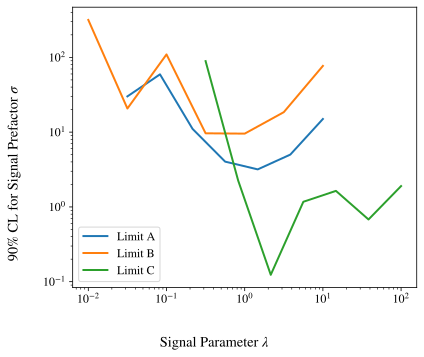

In [132]:
fig, ax = plt.subplots(1,1,figsize=(6,5), sharex=True, sharey=True)

ax.loglog(pars_alice, np.array(limit_alice)/EXPOSURE[0], label='Limit ' + NAMES[0], linewidth=2, color='C0')
ax.loglog(pars_bob, np.array(limit_bob)/EXPOSURE[1], label='Limit ' + NAMES[1], linewidth=2, color='C1')
ax.loglog(pars_carol, np.array(limit_carol)/EXPOSURE[2], label='Limit ' + NAMES[2], linewidth=2, color='C2')
ax.legend(loc='lower left')

fig.supxlabel('Signal Parameter $\lambda$')
fig.supylabel('90% CL for Signal Prefactor $\sigma$')

plt.tight_layout()
plt.savefig('plots/lh_limits_individual.pdf')
plt.show()

Test for multiple measurements.

In [140]:
get_limit_lh(dm_pars=[1], 
             densities=[density_alice_nb, density_bob_nb], 
             x0s=[x0_alice, x0_bob], 
             datas=[data_alice[0], data_bob[0]],
             grids=grids[[0,1]], 
             efficiencies=efficiencies[[0,1]], 
             exposures=EXPOSURE[[0,1]], 
             bndss=[bnds_alice, bnds_bob],
             )

get_limit_lh(dm_pars=[1], 
             densities=[density_bob_nb, density_carol_nb, ], 
             x0s=[x0_bob, x0_carol,], 
             datas=[data_bob[0], data_carol[0], ],
             grids=grids[[1,2]], 
             efficiencies=efficiencies[[1,2]], 
             exposures=EXPOSURE[[1,2]], 
             bndss=[bnds_bob, bnds_carol],
            )

get_limit_lh(dm_pars=[1], 
             densities=[density_alice_nb, density_bob_nb, density_carol_nb, ], 
             x0s=[x0_alice, x0_bob, x0_carol,], 
             datas=[data_alice[0], data_bob[0], data_carol[0], ],
             grids=grids[[0,1,2]], 
             efficiencies=efficiencies[[0,1,2]], 
             exposures=EXPOSURE[[0,1,2]], 
             bndss=[bnds_alice, bnds_bob, bnds_carol],
            )

  0%|          | 0/1 [00:00<?, ?it/s]

[162.15618968757593]

Finally, some combined limits.

In [6]:
# Load the limits from the files

limit_alice = np.array([np.loadtxt(f'data/limit/limit_a_{i}.txt') for i in range(NMBR_REPETITIONS)])
limit_bob = np.array([np.loadtxt(f'data/limit/limit_b_{i}.txt') for i in range(NMBR_REPETITIONS)])
limit_carol = np.array([np.loadtxt(f'data/limit/limit_c_{i}.txt') for i in range(NMBR_REPETITIONS)])

print('Calculate two-experiment Limits...')

limit_ab = np.array([np.loadtxt(f'data/limit/limit_ab_{i}.txt') for i in range(NMBR_REPETITIONS)])
limit_ac = np.array([np.loadtxt(f'data/limit/limit_ac_{i}.txt') for i in range(NMBR_REPETITIONS)])
limit_bc = []
for i in range(NMBR_REPETITIONS):
    try:
        limit_bc.append(np.loadtxt(f'data/limit/limit_bc_{i}.txt'))
    except:
        pass
limit_bc = np.array(limit_bc)
               
print('Calculate combined Limit ...')

# limit_all = np.array([np.loadtxt(f'data/limit/limit_abc_{i}.txt') for i in range(NMBR_REPETITIONS)])

limit_all = []
for i in range(NMBR_REPETITIONS):
    try:
        limit_all.append(np.loadtxt(f'data/limit/limit_all_{i}.txt'))
    except:
        pass
limit_all = np.array(limit_all)


Calculate two-experiment Limits...
Calculate combined Limit ...


And lets do some plots.

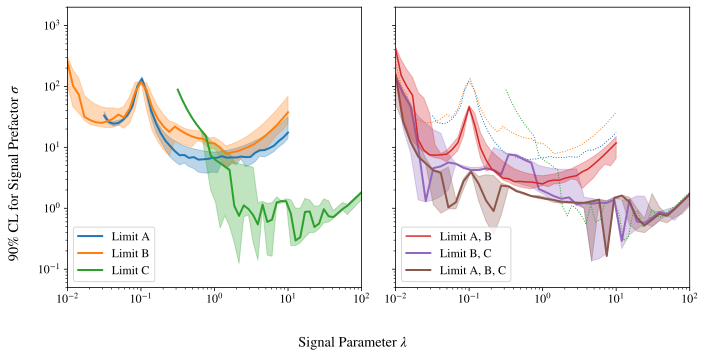

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

axes[0].loglog(limit_alice[0,:,0], np.quantile(limit_alice[:,:,1], q=0.5, axis=0), label='Limit ' + NAMES[0], linewidth=2, color='C0')
axes[0].loglog(limit_bob[0,:,0], np.quantile(limit_bob[:,:,1], q=0.5, axis=0), label='Limit ' + NAMES[1], linewidth=2, color='C1')
axes[0].loglog(limit_carol[0,:,0], np.quantile(limit_carol[:,:,1], q=0.5, axis=0), label='Limit ' + NAMES[2], linewidth=2, color='C2')

axes[0].fill_between(limit_alice[0,:,0], y1=np.quantile(limit_alice[:,:,1], q=0.75, axis=0),
                    y2=np.quantile(limit_alice[:,:,1], q=0.25, axis=0), color='C0', alpha=0.3)
axes[0].fill_between(limit_bob[0,:,0], y1=np.quantile(limit_bob[:,:,1], q=0.75, axis=0),
                   y2=np.quantile(limit_bob[:,:,1], q=0.25, axis=0), color='C1', alpha=0.3)
axes[0].fill_between(limit_carol[0,:,0], y1=np.quantile(limit_carol[:,:,1], q=0.75, axis=0),
                    y2=np.quantile(limit_carol[:,:,1], q=0.25, axis=0), color='C2', alpha=0.3)
axes[0].legend(loc='lower left')

axes[1].loglog(limit_alice[0,:,0], np.quantile(limit_alice[:,:,1], q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C0')
axes[1].loglog(limit_bob[0,:,0], np.quantile(limit_bob[:,:,1], q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C1')
axes[1].loglog(limit_carol[0,:,0], np.quantile(limit_carol[:,:,1], q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C2')

axes[1].loglog(limit_ab[0,:,0], np.quantile(limit_ab[:,:,1], q=0.5, axis=0), label='Limit ' + NAMES[0] + ', ' + NAMES[1], color='C3', zorder=15)
# axes[1].loglog(limit_ac[0,:,0], np.quantile(limit_ac[:,:,1], q=0.5, axis=0), label='Limit ' + NAMES[0] + ', ' + NAMES[2], linewidth=2, color='C6')
axes[1].loglog(limit_bc[0,:,0], np.quantile(limit_bc[:,:,1], q=0.5, axis=0), label='Limit ' + NAMES[1] + ', ' + NAMES[2], linewidth=2, color='C4')
axes[1].loglog(limit_all[0,:,0], np.quantile(limit_all[:,:,1], q=0.5, axis=0), label='Limit ' + NAMES[0] + ', ' + NAMES[1] + ', ' + NAMES[2], linewidth=2, color='C5')

axes[1].fill_between(limit_ab[0,:,0], y1=np.quantile(limit_ab[:,:,1], q=0.75, axis=0),
                    y2=np.quantile(limit_ab[:,:,1], q=0.25, axis=0), color='C3', alpha=0.3, zorder=15)
# axes[1].fill_between(limit_ac[0,:,0], y1=np.quantile(limit_ac[:,:,1], q=0.75, axis=0),
#                     y2=np.quantile(limit_ac[:,:,1], q=0.25, axis=0), color='C6', alpha=0.3, zorder=15)
axes[1].fill_between(limit_bc[0,:,0], y1=np.quantile(limit_bc[:,:,1], q=0.75, axis=0),
                    y2=np.quantile(limit_bc[:,:,1], q=0.25, axis=0), color='C4', alpha=0.3)
axes[1].fill_between(limit_all[0,:,0], y1=np.quantile(limit_all[:,:,1], q=0.75, axis=0),
                    y2=np.quantile(limit_all[:,:,1], q=0.25, axis=0), color='C5', alpha=0.3)

axes[1].set_xlim(1e-2,1e2)
axes[1].set_ylim(5e-2,2e3)
axes[1].legend(loc='lower left')

fig.supxlabel('Signal Parameter $\lambda$')
fig.supylabel('90% CL for Signal Prefactor $\sigma$')

plt.tight_layout()
plt.savefig('plots/lh_limits.pdf')
plt.show()

Done.